In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import missingno as msno
from yellowbrick.style import set_palette
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.target import ClassBalance
#plt.style.use sns poster or other presentation aesthetic style(s)
plt.style.use('seaborn-talk')
# set_palette('colorblind')
from datetime import datetime

<ipython-input-1-d50ec9372cf6>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


In [2]:
from sklearn.preprocessing import MinMaxScaler

from yellowbrick.cluster import InterclusterDistance
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

from sklearn.metrics import cohen_kappa_score
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from pyod.models.iforest import IForest
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import EasyEnsembleClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/dwaraga/big_startup_secsees_dataset.csv')

In [5]:
data.shape

(66368, 14)

## Filtering for US Data

In [6]:
data = data[data['country_code'] != 'USA']

In [7]:
data.shape

(28767, 14)

## Dropping rows where funding_total_usd was not reported

In [8]:
data['funding_total_usd'] = data['funding_total_usd'].replace('-',0)

In [9]:
data['funding_total_usd'] = data['funding_total_usd'].astype(float)

## Droping null Values from founded_at Column

In [10]:
data = data.dropna()

## Considering companies founded after 2009

In [11]:
data['founded_at'] = data['founded_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['first_funding_at'] = data['first_funding_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
data['last_funding_at'] = data['last_funding_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

In [12]:
data['founded_Year'] = data['founded_at'].apply(lambda x:x.year)

In [13]:
data = data[data['founded_Year'] > 2009]

## Dropping Duplicates

In [14]:
data.drop_duplicates(keep=False, inplace=True)

<ipython-input-14-ec62a0ea1113>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(keep=False, inplace=True)


In [15]:
data['final_status'] = data['status'].apply(lambda x:0 if x in ('closed') else 1 )

<ipython-input-15-09324a0e710e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['final_status'] = data['status'].apply(lambda x:0 if x in ('closed') else 1 )


In [16]:
data['market'] = data['category_list'].apply(lambda x:x.split('|')[0])

<ipython-input-16-9f79caeb6ab6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['market'] = data['category_list'].apply(lambda x:x.split('|')[0])


## Dropping permalink, homepage_url, name, category_list column

In [17]:
data.drop(['permalink', 'homepage_url', 'name', 'category_list'], axis=1, inplace= True)

<ipython-input-17-ed4283ce3cba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['permalink', 'homepage_url', 'name', 'category_list'], axis=1, inplace= True)


In [18]:
data

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_Year,final_status,market
9,4.000000e+04,operating,CHL,12,Santiago,Las Condes,1,2012-01-01,2013,2013,2012,1,E-Commerce
18,4.400000e+06,operating,GBR,H9,London,London,2,2013-01-01,2013,2014,2013,1,Education
25,1.066177e+07,operating,FRA,A8,Paris,Paris,5,2010-11-20,2012,2015,2010,1,Local Businesses
26,8.900000e+06,operating,FRA,A9,Montpellier,Montpellier,1,2012-01-01,2015,2015,2012,1,Cosmetics
33,0.000000e+00,operating,CAN,ON,Toronto,Toronto,2,2012-03-03,2013,2014,2012,1,Advertising
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66323,2.000000e+07,operating,RUS,48,Moscow,Moscow,2,2011-01-01,2011,2014,2011,1,Music
66348,1.984930e+05,operating,GBR,H9,London,London,2,2014-01-01,2014,2014,2014,1,Crowdsourcing
66354,1.475000e+07,operating,GBR,A4,Bath,Bath,4,2011-11-30,2012,2014,2011,1,Software
66362,1.120000e+06,operating,GBR,H9,London,London,3,2014-01-28,2014,2015,2014,1,Analytics


## Dropping city due to redundant data with region

In [19]:
data.drop('city',axis=1,inplace=True)

In [20]:
data

,funding_total_usd,status,country_code,state_code,region,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_Year,final_status,market
9,4.000000e+04,operating,CHL,12,Santiago,1,2012-01-01,2013,2013,2012,1,E-Commerce
18,4.400000e+06,operating,GBR,H9,London,2,2013-01-01,2013,2014,2013,1,Education
25,1.066177e+07,operating,FRA,A8,Paris,5,2010-11-20,2012,2015,2010,1,Local Businesses
26,8.900000e+06,operating,FRA,A9,Montpellier,1,2012-01-01,2015,2015,2012,1,Cosmetics
33,0.000000e+00,operating,CAN,ON,Toronto,2,2012-03-03,2013,2014,2012,1,Advertising
...,...,...,...,...,...,...,...,...,...,...,...,...
66323,2.000000e+07,operating,RUS,48,Moscow,2,2011-01-01,2011,2014,2011,1,Music
66348,1.984930e+05,operating,GBR,H9,London,2,2014-01-01,2014,2014,2014,1,Crowdsourcing
66354,1.475000e+07,operating,GBR,A4,Bath,4,2011-11-30,2012,2014,2011,1,Software
66362,1.120000e+06,operating,GBR,H9,London,3,2014-01-28,2014,2015,2014,1,Analytics


## Creating new columns

In [21]:
data['funding_diff'] = (data['last_funding_at'] - data['first_funding_at'])
data['years_operating'] = (2023 - data['founded_Year'])

In [22]:
data

,funding_total_usd,status,country_code,state_code,region,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_Year,final_status,market,funding_diff,years_operating
9,4.000000e+04,operating,CHL,12,Santiago,1,2012-01-01,2013,2013,2012,1,E-Commerce,0,11
18,4.400000e+06,operating,GBR,H9,London,2,2013-01-01,2013,2014,2013,1,Education,1,10
25,1.066177e+07,operating,FRA,A8,Paris,5,2010-11-20,2012,2015,2010,1,Local Businesses,3,13
26,8.900000e+06,operating,FRA,A9,Montpellier,1,2012-01-01,2015,2015,2012,1,Cosmetics,0,11
33,0.000000e+00,operating,CAN,ON,Toronto,2,2012-03-03,2013,2014,2012,1,Advertising,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66323,2.000000e+07,operating,RUS,48,Moscow,2,2011-01-01,2011,2014,2011,1,Music,3,12
66348,1.984930e+05,operating,GBR,H9,London,2,2014-01-01,2014,2014,2014,1,Crowdsourcing,0,9
66354,1.475000e+07,operating,GBR,A4,Bath,4,2011-11-30,2012,2014,2011,1,Software,2,12
66362,1.120000e+06,operating,GBR,H9,London,3,2014-01-28,2014,2015,2014,1,Analytics,1,9


In [23]:
date_cols = ['first_funding_at', 'last_funding_at']
data = pd.concat([data, pd.get_dummies(data[date_cols].astype(str))], axis=1)
data = data.drop(date_cols,axis=1)

## Performing ONE HOT Encoding

In [24]:
data = pd.concat([data, pd.get_dummies(data['market'])], axis=1)
data.drop('market',axis=1,inplace=True)
data = pd.concat([data, pd.get_dummies(data['country_code'])], axis=1)
data.drop('country_code',axis=1,inplace=True)
data = pd.concat([data, pd.get_dummies(data['region'])], axis=1)
data.drop('region',axis=1,inplace=True)

In [25]:
data

,funding_total_usd,status,state_code,funding_rounds,founded_at,founded_Year,final_status,funding_diff,years_operating,first_funding_at_1996,...,Yangon,Yerevan,York,Yucatan,Yverdon-les-bains,Zagreb,Zaragoza,Zhengzhou,Zurich,Ã‡an
9,4.000000e+04,operating,12,1,2012-01-01,2012,1,0,11,0,...,0,0,0,0,0,0,0,0,0,0
18,4.400000e+06,operating,H9,2,2013-01-01,2013,1,1,10,0,...,0,0,0,0,0,0,0,0,0,0
25,1.066177e+07,operating,A8,5,2010-11-20,2010,1,3,13,0,...,0,0,0,0,0,0,0,0,0,0
26,8.900000e+06,operating,A9,1,2012-01-01,2012,1,0,11,0,...,0,0,0,0,0,0,0,0,0,0
33,0.000000e+00,operating,ON,2,2012-03-03,2012,1,1,11,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66323,2.000000e+07,operating,48,2,2011-01-01,2011,1,3,12,0,...,0,0,0,0,0,0,0,0,0,0
66348,1.984930e+05,operating,H9,2,2014-01-01,2014,1,0,9,0,...,0,0,0,0,0,0,0,0,0,0
66354,1.475000e+07,operating,A4,4,2011-11-30,2011,1,2,12,0,...,0,0,0,0,0,0,0,0,0,0
66362,1.120000e+06,operating,H9,3,2014-01-28,2014,1,1,9,0,...,0,0,0,0,0,0,0,0,0,0


## creating new columns

In [26]:
data['per_round'] = data['funding_total_usd'] / data['funding_rounds']

## dropping state_code, founded_year, founded_at and status column

In [27]:
data.drop(['state_code','founded_Year','founded_at','status'], inplace=True, axis=1)

## Setting X and Y

In [28]:
X = data.drop('final_status',axis=1)
y = data['final_status']

In [29]:
data

,funding_total_usd,funding_rounds,final_status,funding_diff,years_operating,first_funding_at_1996,first_funding_at_1998,first_funding_at_2001,first_funding_at_2003,first_funding_at_2004,...,Yerevan,York,Yucatan,Yverdon-les-bains,Zagreb,Zaragoza,Zhengzhou,Zurich,Ã‡an,per_round
9,4.000000e+04,1,1,0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.000000e+04
18,4.400000e+06,2,1,1,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.200000e+06
25,1.066177e+07,5,1,3,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.132355e+06
26,8.900000e+06,1,1,0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.900000e+06
33,0.000000e+00,2,1,1,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66323,2.000000e+07,2,1,3,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000e+07
66348,1.984930e+05,2,1,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.924650e+04
66354,1.475000e+07,4,1,2,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.687500e+06
66362,1.120000e+06,3,1,1,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.733333e+05


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [31]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

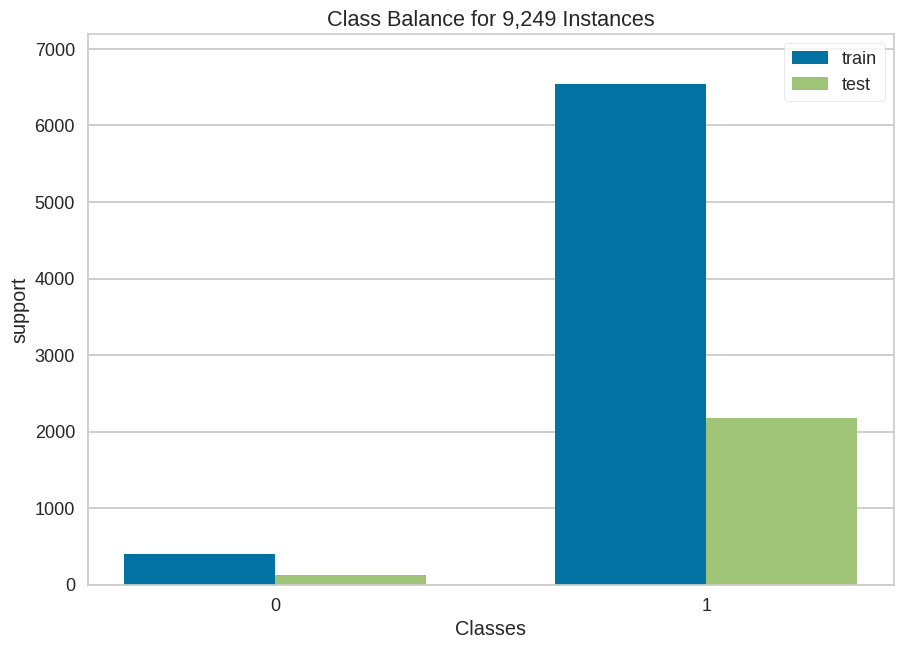

<Axes: title={'center': 'Class Balance for 9,249 Instances'}, xlabel='Classes', ylabel='support'>

In [32]:
visualizer = ClassBalance(labels=[0, 1])

visualizer.fit(y_train,y_test)
visualizer.ax.set_xlabel("Classes")
visualizer.ax.set_ylabel("Amount of Occurrences of Class")
visualizer.show()

## Modelling

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

from sklearn import metrics

from sklearn.linear_model import LogisticRegression

In [34]:
def classify(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''Passed a classifier and appropriate test-train split, displays a classification report, class prediction error,
    and several metrics- f1 weighted, micro, macro and Cohen kappa- to show results. '''
    clf.fit(X_train, y_train)

    best_params = clf.best_params_
    best_model = clf.best_estimator_

    y_pred = best_model.predict(X_test)

    fig = plt.figure(linewidth=10, edgecolor="#04253a")
    clf_rep = ClassificationReport(clf, classes=[0,1], support=True)
    clf_rep.fit(X_train, y_train)
    clf_rep.score(X_test, y_test)
    clf_rep.show()

    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    type_1_error = fp
    type_2_error = fn
    sensitivity = recall_score(y_test, y_pred)

    table_list = []
    table_list.append(accuracy)
    table_list.append(specificity)
    table_list.append(type_1_error)
    table_list.append(type_2_error)
    table_list.append(sensitivity)

#     print('Accuracy - ',accuracy)
#     print('Specificity - ',specificity)
#     print('Sensitivity - ', sensitivity)
#     print('Type I Error - ', type_1_error)
#     print('Type II Error - ', type_2_error)

    auc = metrics.roc_auc_score(y_test, y_pred)

    false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

    plt.figure(figsize=(10, 8), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'g')
    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print('=============================================================================')

    from yellowbrick.classifier import ClassPredictionError
    fig = plt.figure(linewidth=10, edgecolor="#04253a")
    pred_error = ClassPredictionError(clf, classes=[0,1])
    pred_error.fit(X_train, y_train)
    pred_error.score(X_test, y_test)

    pred_error.show()
    print(f"^^^ Classification Report for {clf.__class__.__name__} ^^^")
    print(f"F1 weighted score is {f1_score(y_test, y_pred, average='weighted')}")
    print(f"F1 micro score is {f1_score(y_test, y_pred, average='micro')}")
    print(f"F1 macro score is {f1_score(y_test, y_pred, average='macro')}")
    print(f"Cohen kappa score is {cohen_kappa_score(y_test, y_pred)}")
    plt.tight_layout()

    return table_list

In [35]:
def classify_multiple(clfs, X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test, kind=None):
    '''When passed multiple classifiers and a test-train split, runs classify() to run each together. Optional
    kind parameter helps to print out what sort of classifiers are being used.'''
    if kind == "balanced":
        print("Balanced Classifiers Report")
    elif kind == "boost":
        print("Boosting Classifiers Report")
    else:
        print("Base Classifiers Report")
    table = []
    for clf in clfs:

        table_list = classify(clf[0],X_train=X_tr, y_train=y_tr, X_test=X_te, y_test=y_te)
        table.append(table_list+[clf[1]])
    return table

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [37]:
classifiers1 = [[GridSearchCV(estimator=LogisticRegression(), param_grid={'C': [0.1, 1.0, 10.0],'penalty': ['l1', 'l2'],'solver': ['liblinear', 'saga']}, cv=5),
'Logistic Regression'],
               [GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}, cv=5),'Decision Tree'],
               #[GridSearchCV(estimator=RandomForestClassifier(), param_grid={
    #'n_estimators': [100, 200, 500],
    #'max_depth': [None, 5, 10],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt']
#}, cv=5),'Random Forest'],
               #[GridSearchCV(XGBClassifier(), param_grid={'learning_rate': [0.1, 0.01, 0.001],
    #'max_depth': [3, 5, 7],'n_estimators': [100, 500, 1000]}, cv=5),'XGBoost']
    ]

In [50]:
 classifiers2 = [[GridSearchCV(estimator=RandomForestClassifier(), param_grid={
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}, cv=5),'Random Forest']
               #[GridSearchCV(XGBClassifier(), param_grid={'learning_rate': [0.1, 0.01, 0.001],
    #'max_depth': [3, 5, 7],'n_estimators': [100, 500, 1000]}, cv=5),'XGBoost']
    ]

## ADASYN

In [39]:
from imblearn.over_sampling import ADASYN

print('Original class distribution: \n')
print(y.value_counts())
ada = ADASYN(random_state=0)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_ada).value_counts())

Original class distribution: 

1    8718
0     531
Name: final_status, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    6538
0    6479
Name: final_status, dtype: int64


Base Classifiers Report


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase

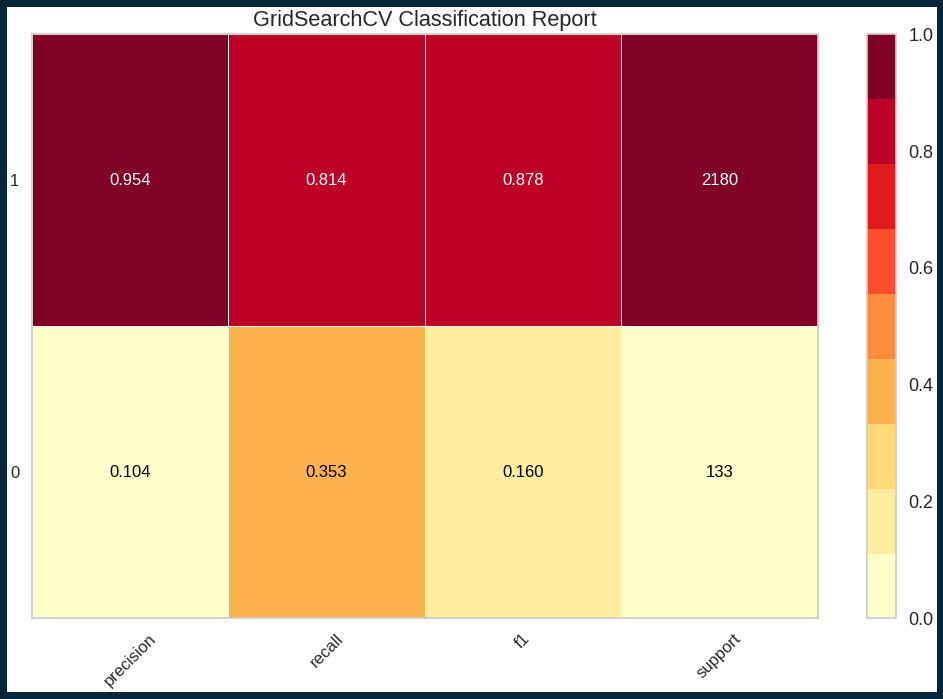

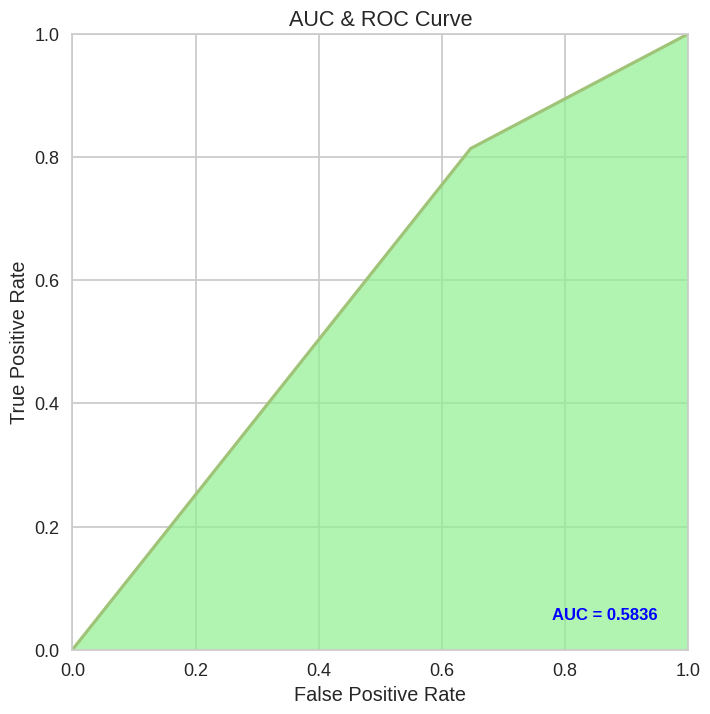

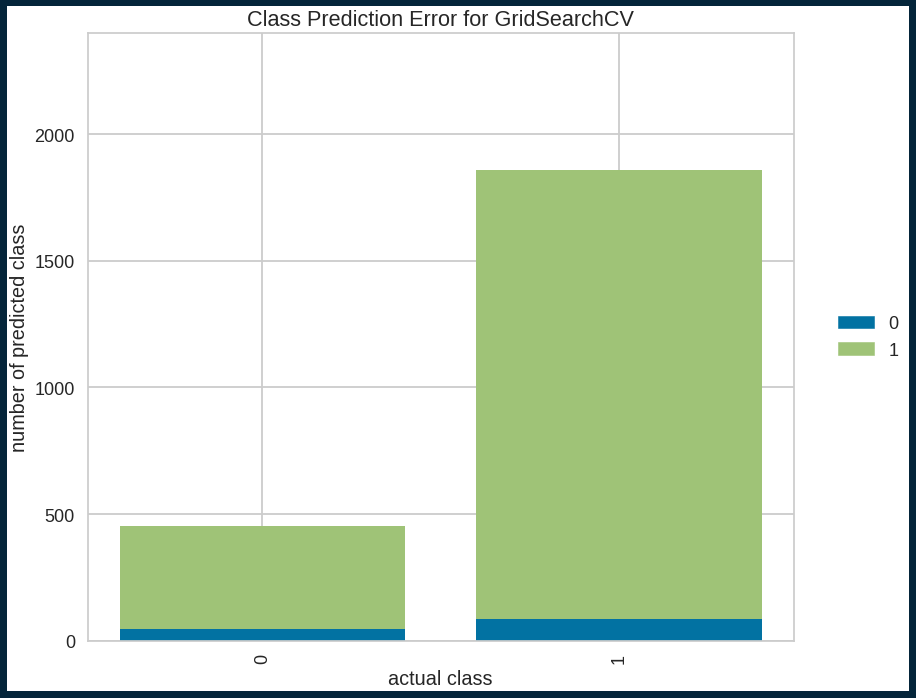

^^^ Classification Report for GridSearchCV ^^^
F1 weighted score is 0.8369430706765714
F1 micro score is 0.787289234760052
F1 macro score is 0.5193136890480857
Cohen kappa score is 0.07848605577689238


<Figure size 1040x715 with 0 Axes>

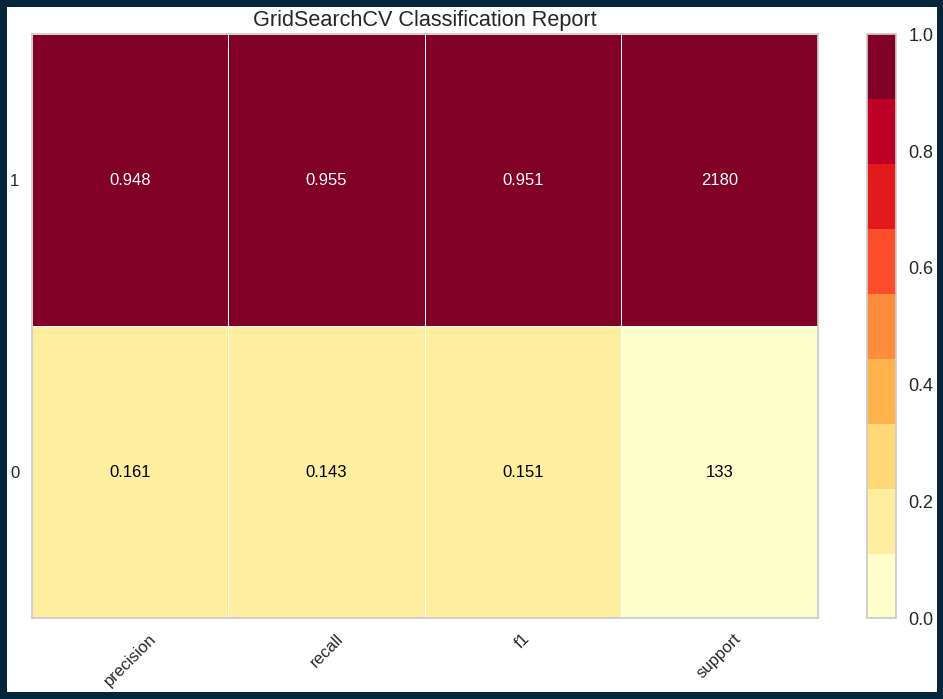

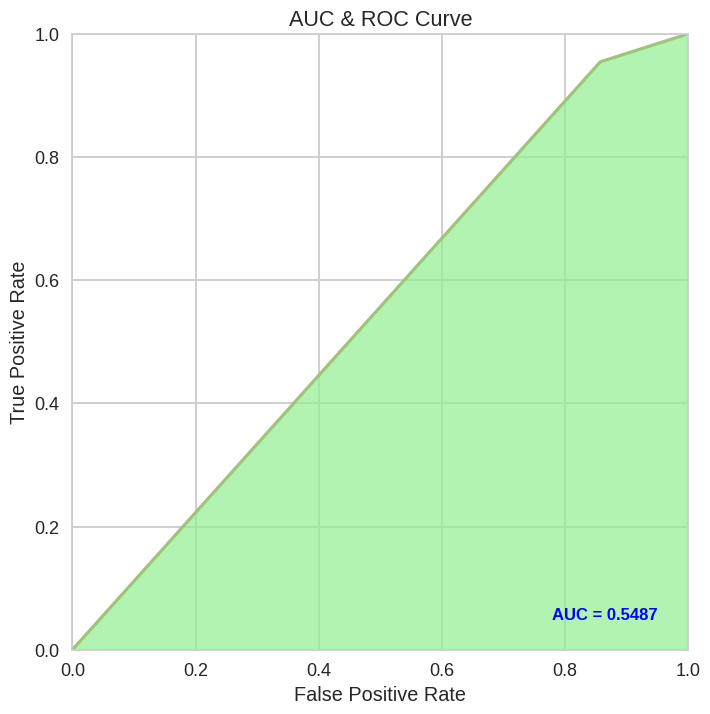

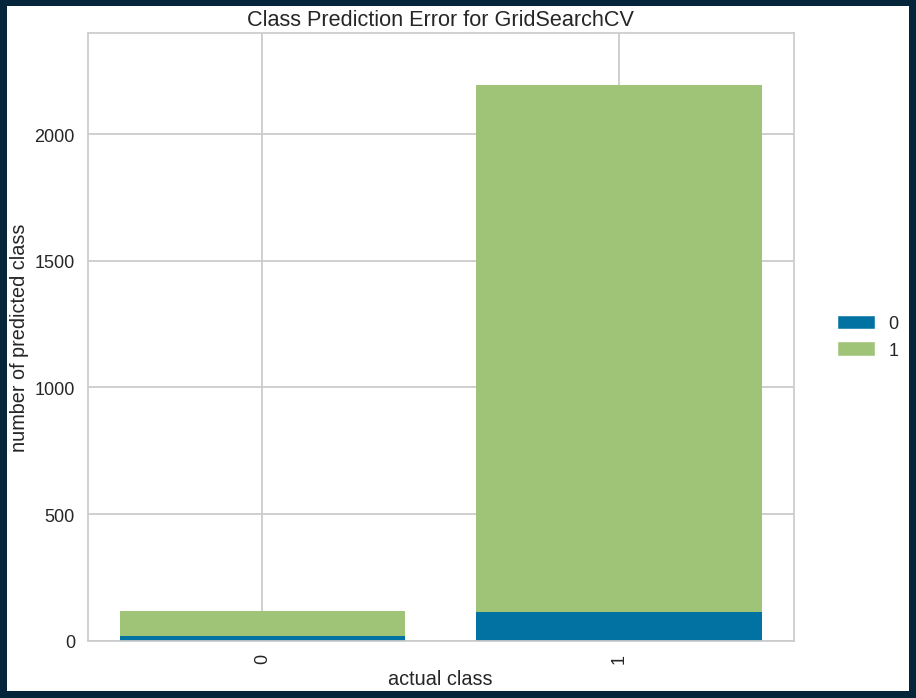

^^^ Classification Report for GridSearchCV ^^^
F1 weighted score is 0.9053180289772909
F1 micro score is 0.907911802853437
F1 macro score is 0.5513543540125214
Cohen kappa score is 0.1028925205990805


<Figure size 1040x715 with 0 Axes>

In [40]:
qq = classify_multiple(classifiers1, X_tr=X_train_ada, X_te=X_test, y_tr=y_train_ada, y_te=y_test)

In [41]:
qq_dataframe = pd.DataFrame(qq)
qq_dataframe.columns = ['Accuracy', 'Specificity','Type I Error', 'Type II Error','Sensitivity', 'Model']

In [42]:
qq_dataframe

,Accuracy,Specificity,Type I Error,Type II Error,Sensitivity,Model
0,0.787289,0.353383,86,406,0.813761,Logistic Regression
1,0.907912,0.142857,114,99,0.954587,Decision Tree


Base Classifiers Report


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

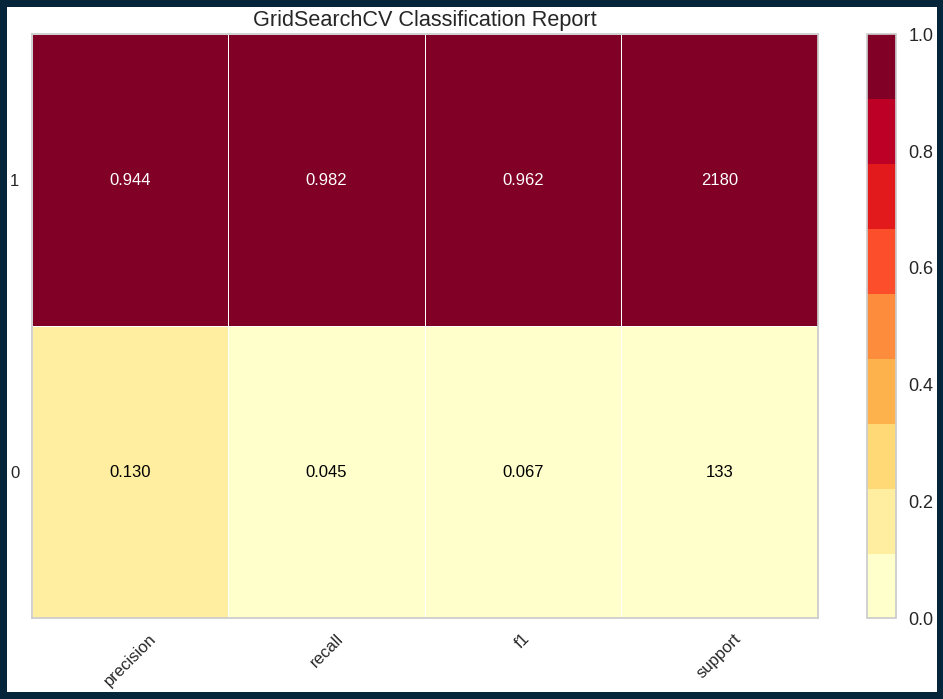

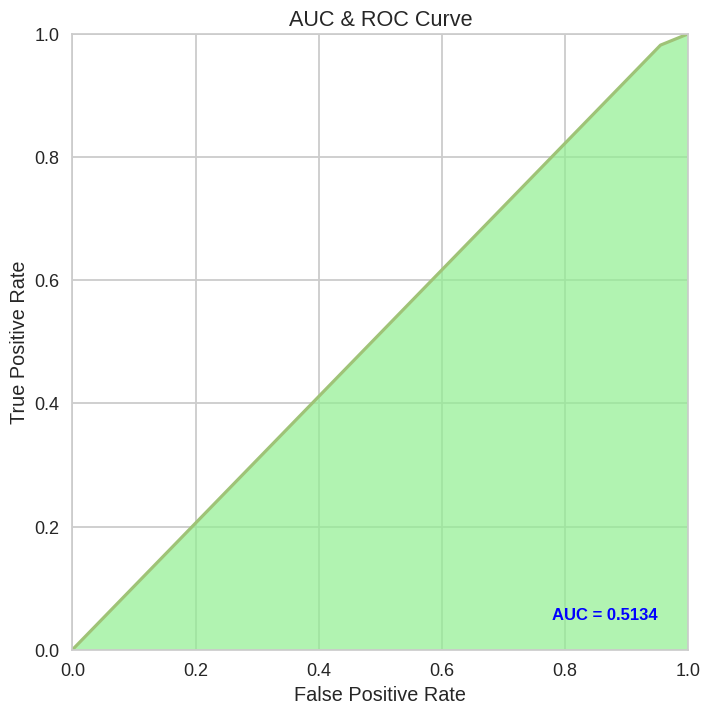

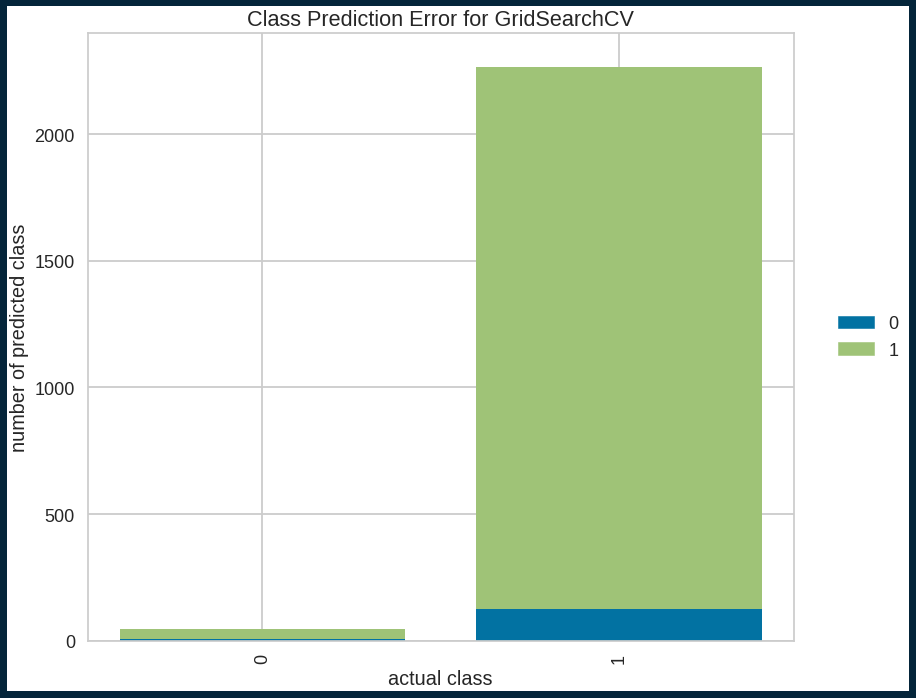

^^^ Classification Report for GridSearchCV ^^^
F1 weighted score is 0.9109596949039044
F1 micro score is 0.9277993947254649
F1 macro score is 0.5147428496770781
Cohen kappa score is 0.03862704739528744


<Figure size 1040x715 with 0 Axes>

In [51]:
qq = classify_multiple(classifiers2, X_tr=X_train_ada, X_te=X_test, y_tr=y_train_ada, y_te=y_test)


In [52]:
qq_dataframe = pd.DataFrame(qq)
qq_dataframe.columns = ['Accuracy', 'Specificity','Type I Error', 'Type II Error','Sensitivity', 'Model']